# Asset Pricing and Portfolio Management #

Suppose that an investor owns, on September 25th, 2008 a portfolio worth \\$10 million consisting of
investments in four stock indices: Dow Jones Industrial Average (DJIA) in the United States, the FTSE
100 in the United Kingdom, the CAC 40 in France, and the Nikkei 225 in Japan. So, let’s suppose that today is September 25th, 2008.
The value of the investment in each index on September 25, 2008, is (in \\$ 000s): \\$4000 in DJIA, \\$3000
in FTSE, \\$1000 in CAC and \$2000 in NIKKEI.

## Question 1 : Using a GARCH model (1,1), estimate the tomorrow's volatility of each of the four indices. Compare the values obtained. Is the result in line with your expectations ? ##



The $garch(p,q)$ model calculates the daily volatility forecast from the $p$ most recent observations $u$
and the $q$ most recent variances $\sigma^2$ :

$$ \sigma_t^2 = \omega + \sum_{i=0}^{p}\alpha_i u_{t-i}^2 + \sum_{i=0}^{q}\beta_i \sigma_{t-i}^2 + \epsilon_t$$

$$ \sigma_t^2 = \omega + \alpha_0 u_t^2 + \alpha_1 u_{t-1}^2 + ... + \alpha_p u_{t-p}^2 + \beta_0 \sigma_t^2 + \beta_1 \sigma_{t-1}^2 + ... + \beta_q \sigma_{t-q}^2 + \epsilon_t$$

With the simplest and most popular $garch(1,1)$ model : 
$$ \sigma_t^2 = \omega + \alpha u_{t-1}^2 + \beta \sigma_{t-1}^2 + \epsilon_t$$ $$(A.1)$$
with :
* $u_{t-1}$ the market latest news
* $\sigma_{t-1}$ the lastest standard deviation
* $\epsilon_t$ the residual error

In [1]:
#import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import datetime

         DJIA     FTSE-500       CAC-40      Nikkei
Day                                                
0    11219.38  11131.84224  6373.894033  131.774435
1    11173.59  11096.28032  6378.161510  134.381821
2    11076.18  11185.35030  6474.040196  135.943301
3    11124.37  11016.70812  6357.485948  135.438090
4    11088.02  11040.72970  6364.764458  134.100284
..        ...          ...          ...         ...
496  11019.69   8878.18400  5689.850489  109.547101
497  11388.44   9734.01951  6230.005762  111.618539
498  11015.69   9656.26083  6181.952576  113.228975
499  10825.17   9438.57988  6033.934595  114.260398
500  11022.06   9599.89840  6200.396069  112.822120

[501 rows x 4 columns]


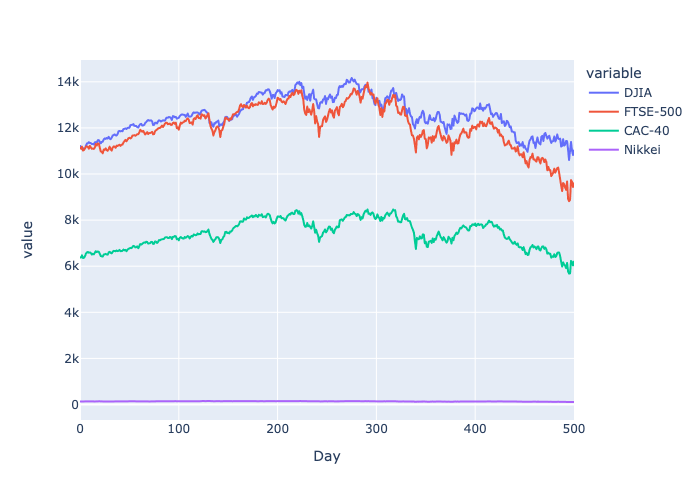

In [2]:
indexes = pd.read_excel('stock_indexes.xls','for_python',index_col=0)
print(indexes)

fig_indexes = px.line(indexes)
fig_indexes.show(renderer="png")

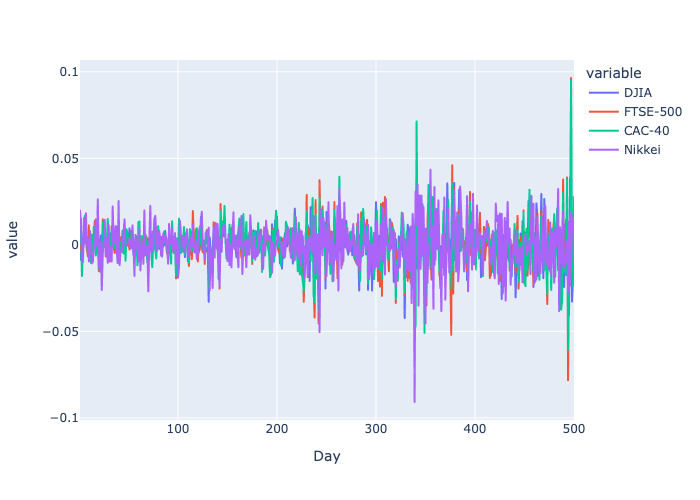

In [3]:
# We start with the calculation of returns (we have the index levels and not the returns)
returns = indexes.apply(pd.DataFrame.pct_change).dropna()
fig_returns = px.line(returns)
fig_returns.show(renderer="png")

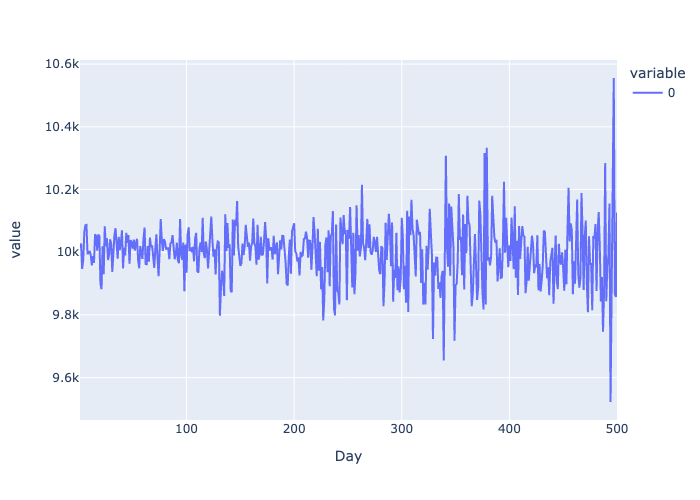

In [4]:
portfolio  = [4000,3000,1000,2000]
lambdas = portfolio / np.sum(portfolio)
portfolio_valuation = np.sum(portfolio * (1 + returns), axis=1)
fig_portfolio = px.line(portfolio_valuation)
fig_portfolio.show(renderer="png")

In [5]:
from arch.univariate import arch_model

# We use normalized returns for the GARCH model to focus on the variance
normalized_returns = returns - np.mean(returns)

models = dict()
# p=1, q=1 : forecast lengths. Both at 1 for garch(1, 1)
# o=0 : no integration (different from IGARCH)
for index in indexes.columns:
    am = arch_model(100 * np.array(normalized_returns[index]), mean='zero',p=1, o=0, q=1, vol='GARCH')
    models[index] = am.fit()
    print(models[index].summary())    

Iteration:      1,   Func. Count:      5,   Neg. LLF: 269383.28894731007
Iteration:      2,   Func. Count:     11,   Neg. LLF: 701.4429284931334
Iteration:      3,   Func. Count:     16,   Neg. LLF: 2424.8164589137905
Iteration:      4,   Func. Count:     21,   Neg. LLF: 806.0475930615592
Iteration:      5,   Func. Count:     26,   Neg. LLF: 700.0291007477424
Iteration:      6,   Func. Count:     31,   Neg. LLF: 268951.13036775636
Iteration:      7,   Func. Count:     38,   Neg. LLF: 700.84774721865
Iteration:      8,   Func. Count:     43,   Neg. LLF: 1082.8148780953195
Iteration:      9,   Func. Count:     48,   Neg. LLF: 694.9524199734253
Iteration:     10,   Func. Count:     53,   Neg. LLF: 689.9671603400541
Iteration:     11,   Func. Count:     57,   Neg. LLF: 689.6884700339114
Iteration:     12,   Func. Count:     61,   Neg. LLF: 689.6826324945141
Iteration:     13,   Func. Count:     65,   Neg. LLF: 689.6810553802809
Iteration:     14,   Func. Count:     69,   Neg. LLF: 1922.746

Covariance estimator: robust


We stored the models into a dictionary and can access the parameters for each index :

In [6]:
print(models["DJIA"].params)

omega       0.003593
alpha[1]    0.022616
beta[1]     0.977384
Name: params, dtype: float64


We can then compute tomorrow's daily volatility for each index using the GARCH formula $(A.1)$ :

In [7]:
garch_vol_tomorrow = dict()
for index in indexes.columns :
    previous_return = returns[index].iloc[-1]
    previous_vol = models[index].conditional_volatility[-1]
    garch_vol_tomorrow[index] = np.sqrt(models[index].params[0] + models[index].params[1] * previous_return + models[index].params[2] * previous_vol)
    print(f"Tomorrow's volatility for {index} : {garch_vol_tomorrow[index]:.2f}")
    

Tomorrow's volatility for DJIA : 1.34
Tomorrow's volatility for FTSE-500 : 1.89
Tomorrow's volatility for CAC-40 : 1.83
Tomorrow's volatility for Nikkei : 1.20


We check in the summaries that, for each index, the P values of the $\omega$, $\alpha$ and $\beta$ parameters are acceptable, ie that for each : $(P>|z|) < 0.05$. It is not always the case here.

In [8]:
threshold = 0.05
corrected_models = models

for index in indexes.columns:
    print(f"{index}:")
    for i, param in enumerate(models[index].params.keys()):
        if models[index].pvalues[i] < threshold :
            print(f" * {param} = {models[index].params[param]:.4f}, p-value = {models[index].pvalues[i]:.4f} < {threshold} : the error margin is low, the coefficient is significant")
        else :
            print(f" * {param} = {models[index].params[param]:.4f}, p-value = {models[index].pvalues[i]:.4f} > {threshold} : the error margin is too high, the coefficient is dropped")
            corrected_models[index].params[param] = 0

DJIA:
 * omega = 0.0036, p-value = 0.7018 > 0.05 : the error margin is too high, the coefficient is dropped
 * alpha[1] = 0.0226, p-value = 0.4370 > 0.05 : the error margin is too high, the coefficient is dropped
 * beta[1] = 0.9774, p-value = 0.0000 < 0.05 : the error margin is low, the coefficient is significant
FTSE-500:
 * omega = 0.0249, p-value = 0.2261 > 0.05 : the error margin is too high, the coefficient is dropped
 * alpha[1] = 0.1627, p-value = 0.0001 < 0.05 : the error margin is low, the coefficient is significant
 * beta[1] = 0.8373, p-value = 0.0000 < 0.05 : the error margin is low, the coefficient is significant
CAC-40:
 * omega = 0.0253, p-value = 0.2158 > 0.05 : the error margin is too high, the coefficient is dropped
 * alpha[1] = 0.1304, p-value = 0.0001 < 0.05 : the error margin is low, the coefficient is significant
 * beta[1] = 0.8680, p-value = 0.0000 < 0.05 : the error margin is low, the coefficient is significant
Nikkei:
 * omega = 0.0637, p-value = 0.0852 > 0.

In [9]:
print(f"Tomorrow's corrected volatility :")
volatility_prevision = dict()
for index in indexes.columns :
    previous_return = returns[index].iloc[-1]
    previous_vol = corrected_models[index].conditional_volatility[-1]
    volatility_prevision[index] = np.sqrt(corrected_models[index].params[0] + corrected_models[index].params[1] * previous_return + corrected_models[index].params[2] * previous_vol)
    print(f" * {index} : {volatility_prevision[index]:.2f}")
    

Tomorrow's corrected volatility :
 * DJIA : 1.33
 * FTSE-500 : 1.88
 * CAC-40 : 1.83
 * Nikkei : 1.17


For the DJIA and the Nikkei, we dropped more than one coefficient. This means that the GARCH model is not a good fit. Instead we will compute the volatility with the basic approach.

In [63]:
kernel_window = 20
for i in ["DJIA", "Nikkei"] :
    kw_sigmas = normalized_returns[i][-kernel_window:]
    volatility_prevision[index] = np.std(kw_sigmas)
    print(f" * {index}'s average volatility over the last {kernel_window} days : {volatility_prevision[index]:.2f}")


 * Nikkei's average volatility over the last 20 days : 0.02
 * Nikkei's average volatility over the last 20 days : 0.02


@Louis tu vas où avec ça ?

In [64]:
for index in indexes.columns:
    print((index, np.sqrt(models[index].forecast().variance[-1:])))

('DJIA',          h.1
499  0.00219)
('FTSE-500',           h.1
499  3.917297)
('CAC-40',           h.1
499  3.692437)
('Nikkei',           h.1
499  0.001479)


## Question 2: Calculate tomorrow's portfolio volatility.

We use the formula to compute the variance of a sum of variables :
$$ \sigma_p^2 = \sum_i \lambda_i \sigma_i^2 + \sum_i \sum_j \lambda_i \lambda_j Cov(X_i, X_j)$$
with
* $\sigma_p$ the variance of portfolio $ p = \sum_i \lambda_i X_i$
* $\sigma_i$ the variance of asset $X_i$
* $\lambda_i$ the weight of $X_i$ in the portfolio, with $0 \leq \lambda_i \leq 1$ and $\sum_i \lambda_i = 1$

In [65]:
covariances = np.cov([returns[i] for i in indexes.columns])
covariances

array([[ 1.22952438e-04,  7.69659054e-05,  7.68251360e-05,
        -9.49348777e-06],
       [ 7.69659054e-05,  2.01397345e-04,  1.82107644e-04,
         3.94430218e-05],
       [ 7.68251360e-05,  1.82107644e-04,  1.95350635e-04,
         4.07812976e-05],
       [-9.49348777e-06,  3.94430218e-05,  4.07812976e-05,
         1.91312901e-04]])

In [66]:
def portfolio_volatility(indexes_volatility) :
    portfolio_variance = 0
    for i, index in enumerate(indexes.columns):
        portfolio_variance += lambdas[i] * indexes_volatility[index]
        for j in range(len(indexes.columns)):
            if j != i :
                portfolio_variance += lambdas[i] * lambdas[j] * covariances[i][j]
    return np.sqrt(portfolio_variance)

In [67]:
portfolio_vol_tomorrow = portfolio_volatility(volatility_prevision)
print(f"Tomorrow's portfolio volatility is {portfolio_vol_tomorrow:.4f}.")

Tomorrow's portfolio volatility is 0.8718.


## Question 3: Deduce an estimate of the daily VaR at the 99% confidence level of this portfolio (use the volatility estimate obtained with the GARCH(1,1) model in the previous question). Which assumptions did you have to use to obtain this estimate?

Assuming that the returns are normally distributed with a mean of 0, we can use the density probability function to calculate the daily 99% VaR.

In [68]:
portfolio_returns = np.sum(returns * lambdas, axis=1)

In [69]:
from scipy.stats import norm

x_level = 0.99
# ppf(q, loc=0, scale=1) with loc = mean and scale = std_dev
VaR_1d_99n = - norm.ppf(1 - x_level, loc=np.mean(portfolio_returns), scale=portfolio_vol_tomorrow)

print(f"The daily VaR at the 99% confidence level is ${VaR_1d_99n:.2f}.")


The daily VaR at the 99% confidence level is $2.03.


A positive VaR mean that we need to put some money aside to hedge the portfolio. Here, we are 99% confident that the portfolio will lose at most the VaR value until the next day.

## Question 4: Is this estimate significantly different from the one you would have obtained without using a GARCH model (1,1)?

Without using a GARCH model (1,1), we could have assumed that the volatility is constant over time and compute it with the basic approach. We start with each index, then compute the portfolio volatility, then the portfolio VaR.

In [70]:
kernel_window = 20

basic_vol_daily = {i : np.std(returns[i][-kernel_window:]) for i in indexes.columns}
basic_portfolio_daily_vol = portfolio_volatility(basic_vol_daily)
x_level = 0.99
basic_VaR_1d_99n = - norm.ppf(1 - x_level, loc=np.mean(portfolio_returns), scale=basic_portfolio_daily_vol)
print(f"The daily VaR at the 99% confidence level with the basic approach is ${basic_VaR_1d_99n:.2f}.")

The daily VaR at the 99% confidence level with the basic approach is $0.37.


The estimates obtained with the basic approach and the GARCH model (1,1) are significantly different. While the basic approach is easier to understand, it puts the same weight on all previous coefficients while the garch model showed at least for some indexes that the previous return ($\alpha$ coefficient) and the previous volatility ($\beta$ coefficient) can have a different influence over tomorrow's returns.

## Question 5: Using the same method, give an estimate of the daily VaR at 99.999%.

In [71]:
x_level = 0.99999
# ppf(q, loc=0, scale=1) with loc = mean and scale = std_dev
VaR_1d_99_999n = - norm.ppf(1 - x_level, loc=np.mean(portfolio_returns), scale=portfolio_vol_tomorrow)

print(f"The daily VaR at the 99.999% confidence level is ${VaR_1d_99_999n:.2f}.")

The daily VaR at the 99.999% confidence level is $3.72.


The 99.999% VaR is higher than the 99% VaR, because with a higher level of confidence, we consider more dreadful - hence costly - scenarios.

## Question 6: Again using the results of the GARCH model (1,1), estimate a 10-day Var at the 99% confidence level. Is the result significantly different from that obtained without using a GARCH model?

Assuming that changes in the portfolio on successive days have independent identical normal distributions with mean zero, we can use the following formula to compute the 10-day VaR :
$$ VaR(T) = VaR(1day) \sqrt{T}$$
hence :
$$ VaR(10day) = VaR(1day) \sqrt{10}$$

In [72]:
VaR_10d_99n = VaR_1d_99n * np.sqrt(10)
print(f"The 10-day VaR at the 99.999% confidence level is ${VaR_10d_99n:.2f}.")

The 10-day VaR at the 99.999% confidence level is $6.41.
